In [1]:
import json
import os
import time
import sys

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
IMG_SIZE = 299
BATCH_SIZE = 32

NUM_KEYPOINTS = 16*2
EPOCHS = NUM_KEYPOINTS*3

BASE_LEARNING_RATE = 1e-4

In [5]:
IMG_DIR = "datasets/mpii/images_selected/"
JSON = "datasets/mpii/trainval.json"

with open(JSON) as infile:
    json_data = json.load(infile)

json_dict = {i["image"]: i for i in json_data}

In [6]:
for k in json_dict.keys():
    for i in range(0,16):
        json_dict[k]['joints'][i].append(json_dict[k]['joints_vis'][i])
    del json_dict[k]['joints_vis']

In [7]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.4, iaa.Affine(rotate=30, scale=(0.5, 0.9))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [8]:
def get(name):
    data = json_dict[name]
    img_data = plt.imread(IMG_DIR + data["image"])

    data["img_data"] = img_data

    return data

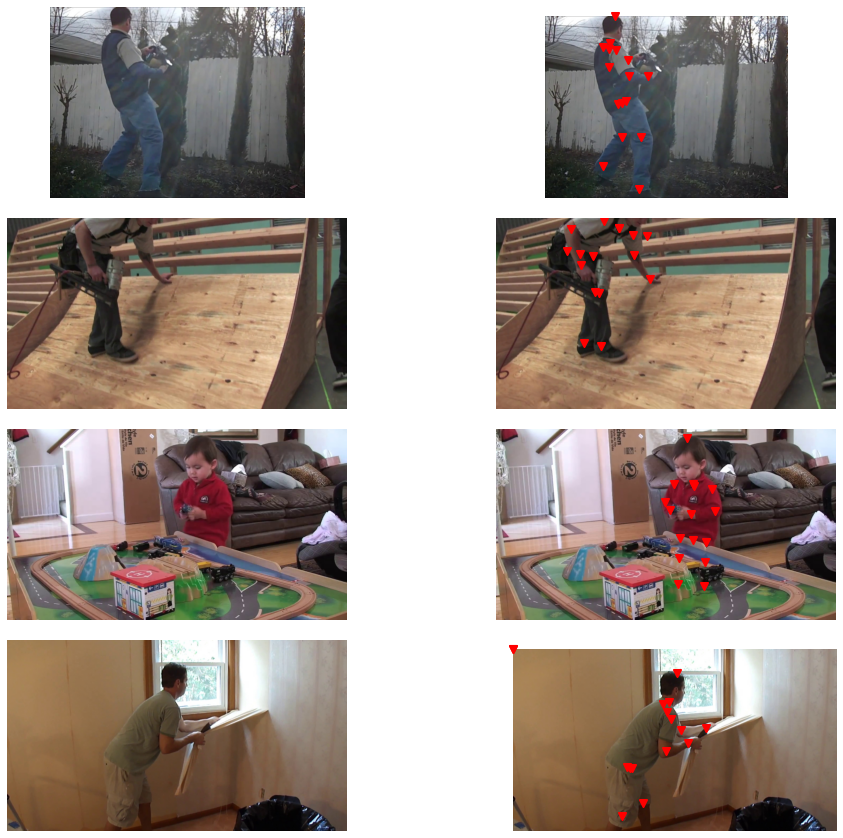

In [9]:

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="v", s=50, linewidths=2
                )
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="v", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [10]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            
            #data = get(key)
            
            data = json_dict[key]
            img_data = plt.imread(IMG_DIR + data["image"])


            
            
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            kps_obj = KeypointsOnImage(kps, shape=img_data.shape)

            (new_image, new_kps_obj) = self.aug(image=img_data, keypoints=kps_obj)
            batch_images[i,] = new_image

            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, NUM_KEYPOINTS)
            del data

        batch_keypoints = batch_keypoints / IMG_SIZE


        
        return (batch_images, batch_keypoints)

In [11]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 464
Total batches in validation set: 82


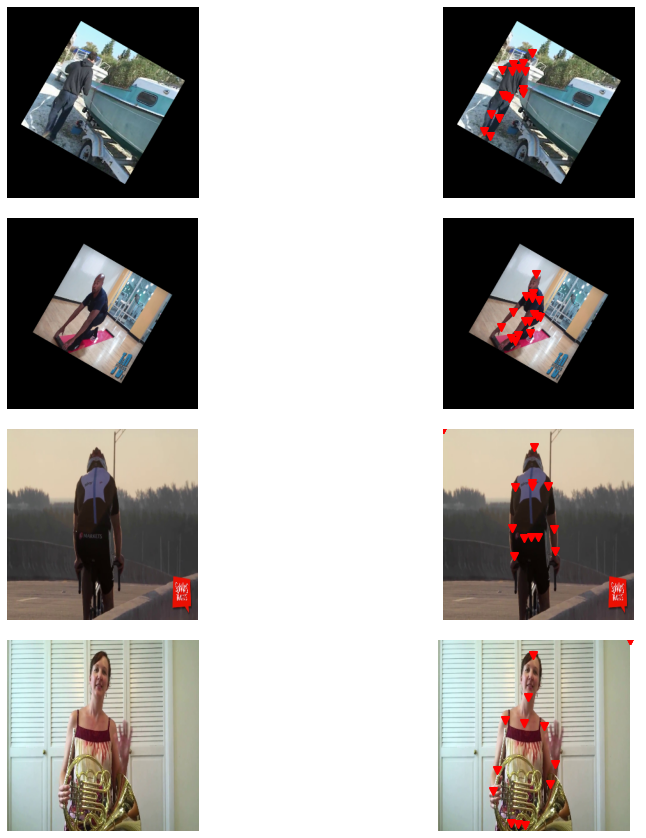

In [12]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 16, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [13]:
BACKBONE = 'inceptionv3'


In [14]:
backbone = tf.keras.applications.InceptionV3(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [15]:
# for i in range(len(backbone.layers)-10):
#     backbone.layers[i].trainable = False
backbone.trainable = False
#backbone.summary()

In [18]:
backbone.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [25]:
inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = backbone(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.SeparableConv2D(
    NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
)(x)
x = tf.keras.layers.SeparableConv2D(
    NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu"
)(x)
outputs = tf.keras.layers.SeparableConv2D(
    NUM_KEYPOINTS, kernel_size=2, strides=1, activation="sigmoid"
)(x)

model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

model.summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 separable_conv2d_14 (Separa  (None, 4, 4, 32)   

In [18]:
# inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = tf.keras.applications.resnet.preprocess_input(inputs)
# x = backbone(x)

# x = tf.keras.layers.Flatten()(x)
# #NEURONS = 1000
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# outputs = tf.keras.layers.Dense(NUM_KEYPOINTS, activation = 'softmax')(x)


# model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

# model.summary()

In [20]:
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['accuracy'], run_eagerly=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], run_eagerly=True)
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])#, run_eagerly=True)
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['mae'], run_eagerly=True)
model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [21]:
!mkdir -p training_ckp/{BACKBONE}
checkpoint_path = "training_ckp/"+BACKBONE+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

SAVE_PERIOD = 10

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                    verbose=1, 
                                                    save_weights_only=True,
                                                    save_freq='epoch',
                                                    #save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH),
                                                )

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 20
                                                          , restore_best_weights = True)

!mkdir -p training_logs/{BACKBONE}
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"training_logs/{BACKBONE}/{time.time()}")

In [23]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=[
                                cp_callback,
                                earlystopping_callback,
                                tensorboard
                              ]
                   )

Epoch 1/96
 68/464 [===>..........................] - ETA: 4:22 - loss: 0.0458 - root_mean_squared_error: 0.2139

KeyboardInterrupt: 

In [ ]:
!mkdir -p saved_model/{BACKBONE}
model.save(f'saved_model/{BACKBONE}/before_finetuning_model.h5')

In [ ]:
for layer in backbone.layers:
    layer.trainable = True
# backbone.trainable = True

print("Number of layers in the base model: ", len(backbone.layers))

In [ ]:
model.summary()

In [ ]:
# fine_tune_at = len(backbone.layers)-10

# for layer in backbone.layers[:fine_tune_at]:
#     layer.trainable = False

In [ ]:
model.summary()

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.Adam(BASE_LEARNING_RATE/10),
#               metrics=['accuracy'])
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE/10),metrics=['accuracy'], run_eagerly=True)
#model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE/10), loss='mean_squared_error', metrics=['mae'], run_eagerly=True)
model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE/10), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
# add checkpoints
!mkdir -p finetuning_ckp/{BACKBONE}
checkpoint_path = "finetuning_ckp/"+BACKBONE+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_path, 
                                                    verbose=1, 
                                                    save_weights_only=True,
                                                    save_freq='epoch',
                                                    )

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)


In [ ]:
FINETUNE_EPOCHS = 20

history_fine = model.fit(train_dataset,
                         epochs=FINETUNE_EPOCHS,
                         #initial_epoch=153,
                         validation_data=validation_dataset,
                         callbacks=[
                                cp_callback,
                                earlystopping_callback,
                                tensorboard
                              ]
                        )


In [ ]:
model.save(f'saved_model/{BACKBONE}/final_model.h5')

In [ ]:

# Keras model converter API uses the default signature automatically.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

!mkdir -p saved_model/{BACKBONE}
open(f"saved_model/{BACKBONE}/model.tflite", "wb").write(tflite_model)